In [8]:
from numba import jit, cuda
import warnings
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time as timess

base_noise_min=-0.005
base_noise_max= 0.005


time=[]
for i in range(-1,1000000):
    time.append(i)           # 1 nano second resolution
ci=0#len(time)//4
cf=len(time)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

In [9]:
# f = open("G_table.txt", "w")
# for j in range(5,185,5):
#     f.write(str(j/10))
#     f.write(' | ')
#     for i in range(360):
#         f.write(str(math.cos(math.radians(i)))+' ')
#     f.write('\n')
# f.close()    
G_table={}
f = open("G_table.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    G_table[tmp_freq]=[]
    for i in tmp:
        G_table[tmp_freq].append(float(i))
f.close()

In [18]:
def interleave(pulses,display=1):
    global ci,cf,fig_x,fig_y,clrs
    jdx=0
    pulse_f=[]
    for j in pulses:
        pulse_f.append([])
        for i in time:
            max_t=[]
            for k in j:
                max_t.append(k[i])
            pulse_f[-1].append(max(max_t))
        if(display):
            jdx+=1
            print(jdx)
            plt.figure(figsize=(fig_x , fig_y))
            idx=0
            for i in j:
                idx+=1
                plt.plot(time[ci:cf],i[ci:cf], color=clrs[idx-1], label=str(idx))
            plt.legend()
            plt.xlabel("independent input pulses")
            plt.show()
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],pulse_f[-1][ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            plt.show()
    return pulse_f

In [19]:
class reciever:
    def __init__(self, id,radar,aircraft):
        global G_table,base_noise_min,base_noise_max,time,receivers_n
        self.id = id                                       # Id of the reciever
        self.pri = radar.pri                               # Pulse Repetition Interval
        self.pwd = radar.pwd                               # Pulse Width
        self.R = math.dist(radar.pos,aircraft.pos)         # Distance between the radar and the aircraft
        self.Pt=radar.Pt                                   # Peak transmitted power
        self.G=radar.G                                     # Antenna Gain
        self.freq = radar.freq                             # carrier frequency
        self.P=(self.Pt*self.G)/(4*math.pi*(self.R**2))    # Power recieved by the aircraft radar reciver
        angle=math.degrees(math.atan2(radar.pos[1]-aircraft.pos[1],radar.pos[0]-aircraft.pos[0]))-aircraft.heading
        while(angle>360):
            angle-=360                                     # Angle between the aircraft and radar
        while(angle<0):
            angle+=360
        self.angle=angle
        a=0.1
        omega=2*np.pi*self.freq/2000
        angl_cond=[]
        self.pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
        for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
            angl_cond.append((360/receivers_n)*(1+2*j)/2)   # based on the above information
            self.pulse_train.append([])
        for i in range(-1,len(time)-1):
            if(i%self.pri<=self.pwd):
                idx=0
                for j in self.pulse_train:
                    if(angl_cond[idx]+90>360):
                        if ((angle>=0 and angle<=angl_cond[idx]-270) or (angle>=angl_cond[idx]-90 and angle<=360)):
                            tmp_n=random.uniform(base_noise_min,base_noise_max)
                            j.append(tmp_n if abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])<base_noise_max else (abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])*(1+a*(np.sin(omega*i)-1))))
                        else:
                            j.append(random.uniform(base_noise_min,base_noise_max))
                    elif(angl_cond[idx]-90<0):
                        if((angle>=0 and angle<=angl_cond[idx]+90) or (angle>=angl_cond[idx]+270 and angle<=360)):
                            tmp_n=random.uniform(base_noise_min,base_noise_max)
                            j.append(tmp_n if abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])<base_noise_max else abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])*(1+a*(np.sin(omega*i)-1)))
                        else:
                            j.append(random.uniform(base_noise_min,base_noise_max))
                    else:
                        if ((angle>=angl_cond[idx]-90 and angle<=angl_cond[idx]+90)):
                            tmp_n=random.uniform(base_noise_min,base_noise_max)
                            j.append(tmp_n if abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])<base_noise_max else (abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])*(1+a*(np.sin(omega*i)-1))))
                        else:
                            j.append(random.uniform(base_noise_min,base_noise_max))
                    idx+=1
            else:
                for j in self.pulse_train:
                    j.append(random.uniform(base_noise_min,base_noise_max))
    def __del__(self):
        pass
            
class radar:
    def __init__(self, id,pri=500,pwd=10,pos=(0,0)):
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt=10                                         # Peak transmitted power
        self.freq=1                                        # frequency range 0.5 to 18 units gigahertz
        self.pos = pos
        self.G=1                                           # Antenna Gainr
    def __del__(self):
        pass
class aircraft:
    def __init__(self, id,pos=(0,0),heading=0):
        self.id = id                                       # Id of the Aircraft
        self.pos = pos                                     # Position of the radar
        self.heading = heading                             # heading of the Aircraft in degrees
    def __del__(self):
        pass

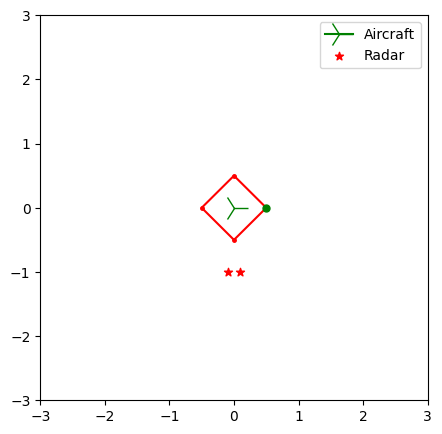

In [20]:
receivers_n=4                # Number of recievers on the aircraft
radars_n=2                   # Number of radars

radar_positions=[]
for i in range(radars_n):
    radar_positions.append((random.uniform(1,2) if random.uniform(-1,1)>0 else random.uniform(-1,-2),random.uniform(1,2) if random.uniform(-1,1)>0 else random.uniform(-1,-2)))
radar_positions = np.array(radar_positions)

radar_positions = np.array([
    # (1,0),
    # (1,1),
    # (0,1),
    # (-1,1),
    # (-1,0),
    (-0.1,-1),
    # (0,-1),
    (0.1,-1),
])

aircraft_0 = aircraft(id=0,pos=(0,0),heading=0)
# aircraft_0 = aircraft(id=0,pos=(random.uniform(-1,1),random.uniform(-1,1)),heading=random.uniform(0,360))

radars=[]
pulses=[]                                   
for i in range(receivers_n):                          
    pulses.append([])

for j in range(radars_n):
    # radar_j = radar(id=j,pri=100000,pwd=9000,pos=radar_positions[0])
    radar_j = radar(id=j,pri=random.randint(100000, 200000),pwd=9000,pos=radar_positions[j])
    pulse_j = reciever(id=j,radar=radar_j,aircraft=aircraft_0)
    radars.append(radar_j)
    for i in range(receivers_n):
        pulses[i].append(pulse_j.pulse_train[i])
    del radar_j;
    del pulse_j;

# radar_1 = radar(id=1,pri=150000,pwd=9000,pos=radar_positions[1])
# pulse_1 = reciever(id=1,radar=radar_1,aircraft=aircraft_0)
# radars.append(radar_1)
# for i in range(receivers_n):
#     pulses[i].append(pulse_1.pulse_train[i])

plt.figure(figsize=(5 , 5))
plt.plot(aircraft_0.pos[0],aircraft_0.pos[1], color='g', marker = '4', markersize=20,label='Aircraft')
tmp_s=0.5
            
tmp_x=[]   
tmp_y=[]
                                 
for j in range(receivers_n+1):
    tmp_x.append(aircraft_0.pos[0]+(tmp_s*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(2*j)/2))))
    tmp_y.append(aircraft_0.pos[1]+(tmp_s*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(2*j)/2))))
            
plt.plot(tmp_x,tmp_y, color='r', marker = '.', markersize=5)
plt.plot(tmp_x[0],tmp_y[0], color='g', marker = '.', markersize=10)
plt.scatter(radar_positions[:,0],radar_positions[:,1], color='r', marker = '*',label='Radar')
plt.legend()
rng=3
plt.xlim([-rng, rng])
plt.ylim([-rng, rng])
plt.show()

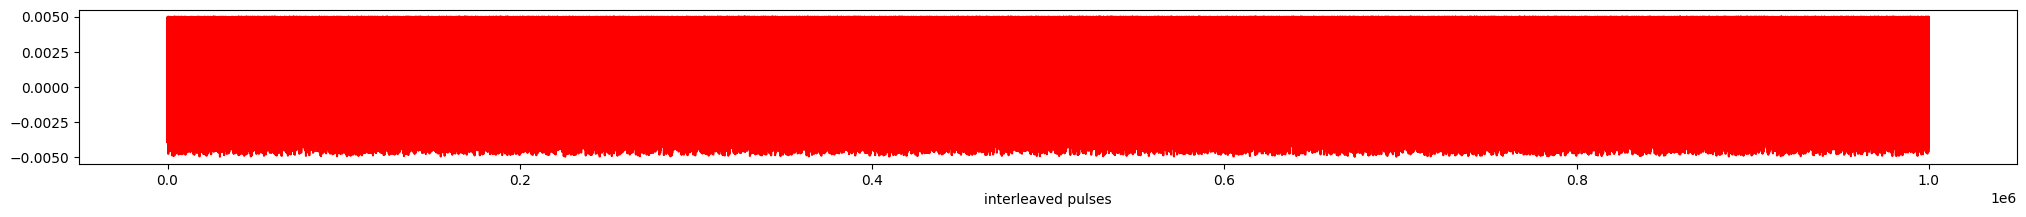

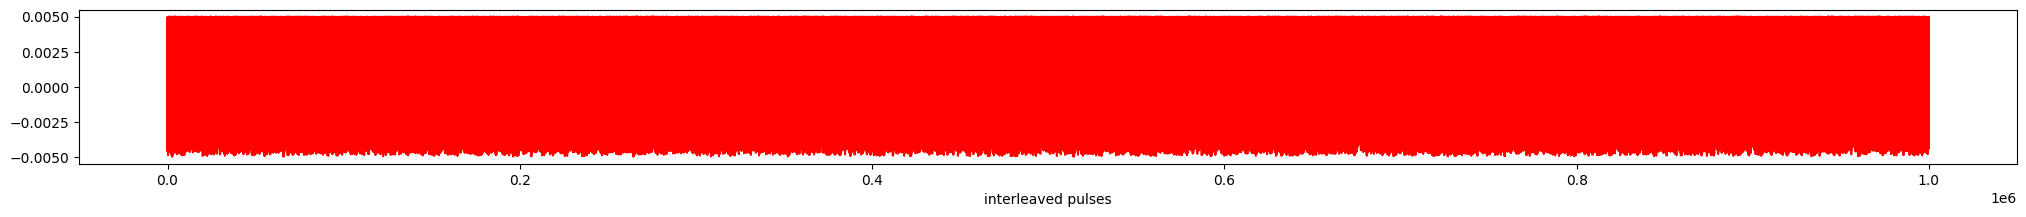

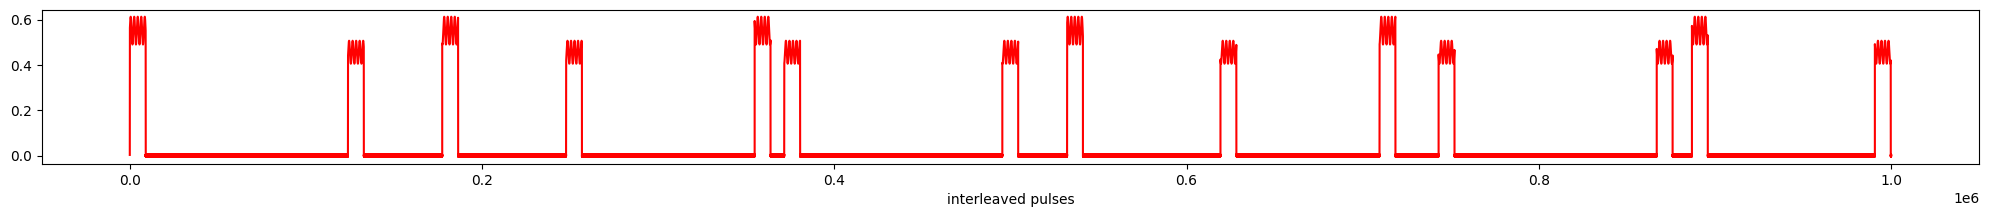

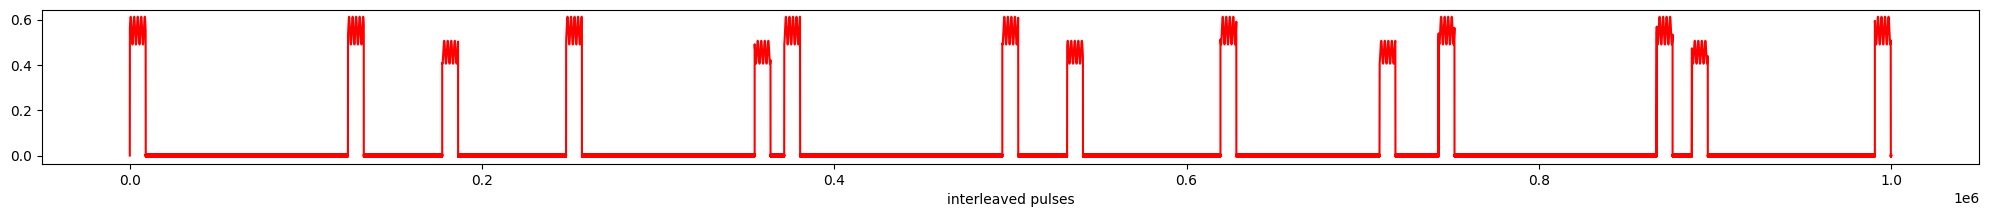

In [23]:
pdw(interleave(pulses,display=0))

In [22]:
def pdw(pulse_f,display=1):
    global fig_x,fig_y
    for i in pulse_f:
        if(display):
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],i[ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            plt.show()